In [135]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

!pip install openpyxl

In [136]:
data = pd.read_excel("data/ESG_raw_data_07_02.xlsx")

In [137]:
variables = ["scope_1", "scope_2", "scope_3", "waste_production",
             "waste_recycling", "water_consumption", "water_withdrawal",
             "energy_consumption", "hours_of_training", "independent_board_members_percentage",
             "legal_costs_paid_for_controversies", "ceo_compensation", "gender_pay_gap"]

variables_env =  ["scope_1", "scope_2", "scope_3", "waste_production",
             "waste_recycling", "water_consumption", "water_withdrawal",
             "energy_consumption"]

# Un peu de Statdesc pour commencer

# Manque d'information et industries polluantes

On étudie la relation entre le manque d'information sur le "gender_pay_gap" et le fait qu'une industrie soit particulièrement polluante ou non, i.e si son "scope_1" moyen est élevé.

Pour commencer, je vais "normaliser" toutes les variables quantitatives par le nombre d'employés dans l'entreprise, afin que ces grandeurs puissent être comparées. Il est important de noter que je ne renomme pas ces variables.

In [138]:
data["scope_1"].head(5)

0    47430.0
1    52730.0
2    57440.0
3    49100.0
4    44700.0
Name: scope_1, dtype: float64

In [139]:
df = data
for x in variables_env :
    df[x] = df[x]/df['employees']
    df = df.rename(columns={x: x + '_per_capita'})

In [140]:
df["scope_1_per_capita"].head(5)

0    0.322653
1    0.384891
2    0.435152
3    0.735030
4    0.565823
Name: scope_1_per_capita, dtype: float64

On calcule alors les moyennes de données manquantes pour le "gender_pay_gap" et pour le "scope_1" par industrie.

In [141]:
missing_mean = df.groupby('primary_industry')['gender_pay_gap'].apply(lambda x: x.isnull().mean())
scope_1_mean = df.groupby('primary_industry')['scope_1_per_capita'].mean()

In [142]:
scope_1_mean = scope_1_mean.dropna()
print(scope_1_mean.sort_values())
scope_1_mean_log = np.log(scope_1_mean)

primary_industry
Insurance Brokers                                     0.123478
Diversified Capital Markets                           0.210797
Systems Software                                      0.220121
Asset Management and Custody Banks                    0.253842
Apparel Retail                                        0.377051
                                                      ...     
Independent Power Producers and Energy Traders     5056.270213
Gold                                               7292.832339
Marine                                            12240.532480
Oil and Gas Storage and Transportation            13145.662761
Electric Utilities                                15354.066107
Name: scope_1_per_capita, Length: 151, dtype: float64


Et on plot tout ça.

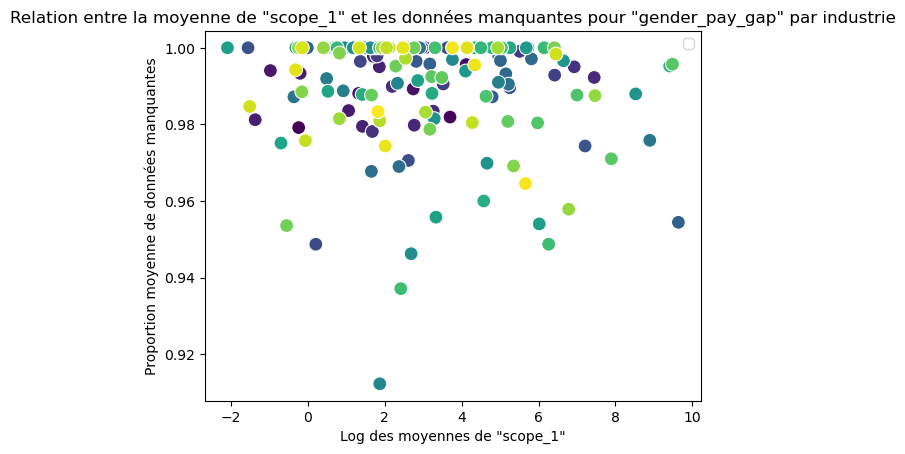

In [143]:
sns.scatterplot(x = scope_1_mean_log, y = missing_mean, hue = missing_mean.index, palette = 'viridis', s = 100)
plt.xlabel('Log des moyennes de "scope_1"')
plt.ylabel('Proportion moyenne de données manquantes')
plt.title('Relation entre la moyenne de "scope_1" et les données manquantes pour "gender_pay_gap" par industrie')
plt.legend('')
#plt.ylim((-10, 2000))
plt.show()

On peut alors effectuer des régressions, on va contrôler sur la région et sur l'année. On en effectue deux : une simple et une avec le "scope_1" en log. Ces régressions sont faites sur chaque entreprise, avec en $Y$ une variable binaire : le fait d'avoir ou non la donnée sur le "gender_pay_gap" et en co-variables : le "scope_1" de l'entreprise (normalisé par son nombre d'employés), la région, l'année. 

In [144]:
from statsmodels.stats import sandwich_covariance

df2 = df

df2['missing'] = df2['gender_pay_gap'].isnull().astype(float)
df2 = df2.dropna(subset=['scope_1_per_capita'])
df2['scope_1_per_capita_log'] = np.log(df2['scope_1_per_capita'])

# Régressions linéaires avec contrôle sur la région et l'année
X1 = df2[['scope_1_per_capita', 'region', 'year', 'primary_industry']]
X1 = pd.get_dummies(X1, columns=['region', 'year', 'primary_industry'], drop_first=True, dtype=float)
X1 = sm.add_constant(X1)

y1 = df2['missing']

model1 = sm.OLS(y1, X1).fit()

X2 = df2[['scope_1_per_capita_log', 'region', 'year', 'primary_industry']]
X2 = pd.get_dummies(X2, columns=['region', 'year', 'primary_industry'], drop_first=True, dtype=float)
X2 = sm.add_constant(X2)

# Pour le log, on doit filtrer les valeurs Nan car il y avait des "scope_1" égaux à 0
mask = ~X2.isin([np.nan, np.inf, -np.inf]).any(axis=1)
X2 = X2[mask]
y2 = df2['missing'][mask]


model_clustered_2 = sm.OLS(y2, X2).fit(cov_type='cluster',
                          cov_kwds={'groups': df2['year'][mask]})

# C'est très très moche comme facon de display le truc mais ca m'a saoulé mdr
for line in model_clustered_2.summary().as_text().splitlines()[:16]:
    print(line[:])

# On peut aussi utiliser le PanelOlS du package linearmodels mais ca m'a deja trop saoulé là -> la
# correction ne permettra que de corriger légèrement la variance mais ca devrait pas changer grand chose


/opt/mamba/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_2885/2745784115.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['scope_1_per_capita_log'] = np.log(df2['scope_1_per_capita'])
/opt/mamba/lib/python3.11/site-packages/statsmodels/base/model.py:1896: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 157, but rank is 2
  warnings.warn('covariance of constraints does not have full '


                            OLS Regression Results                            
Dep. Variable:                missing   R-squared:                       0.094
Model:                            OLS   Adj. R-squared:                  0.081
Method:                 Least Squares   F-statistic:                 3.269e+12
Date:                Wed, 14 Feb 2024   Prob (F-statistic):           3.06e-13
Time:                        12:43:11   Log-Likelihood:                 3554.1
No. Observations:               10687   AIC:                            -6792.
Df Residuals:                   10529   BIC:                            -5643.
Df Model:                         157                                         
Covariance Type:              cluster                                         
                                                                      coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------

# Lien entre "rangs" au sein d'une même industrie (plus utilisé)

On va regarder si on peut mettre en évidence un lien entre être bon en "gender_pay_gap" et être bon en "scope_1" au sein d'une même industrie. Pour cela, on va classer chaque entreprise au sein de son secteur : premièrement en fonction du "gender_pay_gap" et deuxièmement en fonction de ses émissions dans le scope le plus pertinent pour son secteur. Ce scope pertinent sera pris comme le scope où les émissions moyennes du secteur sont les plus importantes.

In [149]:
sector_means = df.groupby('primary_industry').agg({'scope_1_per_capita': 'mean', 'scope_2_per_capita': 'mean', 'scope_3_per_capita': 'mean'})
most_emitting_scope = sector_means.idxmax(axis=1)

nan_industries = most_emitting_scope.isna()
most_emitting_scope = most_emitting_scope.dropna()

print(most_emitting_scope)

primary_industry
Advertising                            scope_3_per_capita
Aerospace and Defense                  scope_3_per_capita
Agricultural Products                  scope_3_per_capita
Agricultural and Farm Machinery        scope_3_per_capita
Air Freight and Logistics              scope_1_per_capita
                                              ...        
Tobacco                                scope_3_per_capita
Trading Companies and Distributors     scope_3_per_capita
Trucking                               scope_3_per_capita
Water Utilities                        scope_1_per_capita
Wireless Telecommunication Services    scope_3_per_capita
Length: 151, dtype: object


/tmp/ipykernel_2885/654674767.py:2: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  most_emitting_scope = sector_means.idxmax(axis=1)


In [150]:
df3 = df

# On enlève toutes les entreprises venant d'un secteur où l'on a pas pu déterminer le "most_emitting_scope"
def nan_industry(row) :
    return nan_industries[row["primary_industry"]]

df3["nan_industry"] = df3.apply(nan_industry, axis = 1)
idx = df3.loc[df3["nan_industry"] == True].index.to_list()
df3 = df3.drop(index = idx)
df3 = df3.drop(columns = ["nan_industry"])

In [151]:
def most_emitting_scope_function(row) :
    return row[most_emitting_scope[row['primary_industry']]]

df3['most_emitting_scope'] = df3.apply(most_emitting_scope_function, axis = 1)
df3 = df3.dropna(subset=['most_emitting_scope'])
df3.head(5)

,company_id,year,company_name,ticker,LEI,isin,Business Desc.,region,hq_country,primary_industry,...,water_consumption_per_capita,water_withdrawal_per_capita,energy_consumption_per_capita,hours_of_training,independent_board_members_percentage,legal_costs_paid_for_controversies,ceo_compensation,gender_pay_gap,missing,most_emitting_scope
0,c67ee84d-5cf4-4cd0-85b9-027ad082748f,2020,Apple Inc.,NasdaqGS:AAPL,HWUPKR0MPOU8FGXBT394,US0378331005,"Apple Inc. designs, manufactures, and markets ...",United States and Canada,United States,"Technology Hardware, Storage and Peripherals",...,33.163265,33.163265,20.538571,NaN,0.008571,0.00,14769259.0,NaN,1.0,153.401361
1,c67ee84d-5cf4-4cd0-85b9-027ad082748f,2019,Apple Inc.,NasdaqGS:AAPL,HWUPKR0MPOU8FGXBT394,US0378331005,"Apple Inc. designs, manufactures, and markets ...",United States and Canada,United States,"Technology Hardware, Storage and Peripherals",...,35.694537,36.441053,21.092555,NaN,0.008571,1.85,11555466.0,NaN,1.0,182.335766
2,c67ee84d-5cf4-4cd0-85b9-027ad082748f,2018,Apple Inc.,NasdaqGS:AAPL,HWUPKR0MPOU8FGXBT394,US0378331005,"Apple Inc. designs, manufactures, and markets ...",United States and Canada,United States,"Technology Hardware, Storage and Peripherals",...,36.099633,37.304867,20.276212,NaN,0.008750,NaN,15682219.0,NaN,1.0,189.924242
3,9ea5e71e-33ac-4916-9c58-50ce9fa54abe,2020,Saudi Arabian Oil Company,SASE:2222,5586006WD91QHB7J4X50,SA14TG012N13,Saudi Arabian Oil Company operates as an integ...,Africa / Middle East,Saudi Arabia,Integrated Oil and Gas,...,541.167665,541.167665,2238.982036,NaN,0.454540,0.00,NaN,NaN,1.0,28097.683982
6,0fc16315-00da-4223-9cd5-0b09f6274aeb,2020,Microsoft Corporation,NasdaqGS:MSFT,INR2EJN1ERAN0W5ZP974,US5949181045,"Microsoft Corporation develops, licenses, and ...",United States and Canada,United States,Systems Software,...,24.335214,46.043442,65.995092,NaN,0.916670,0.00,NaN,NaN,1.0,66.366871


/tmp/ipykernel_2885/2897180220.py:5: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x = 'rank_emissions', y = 'rank_gender', data = df3, palette='viridis', s=100)


Text(0.5, 1.0, "Relation entre rang d'émissions et de gender_pay_gap au sein d'une même industrie")

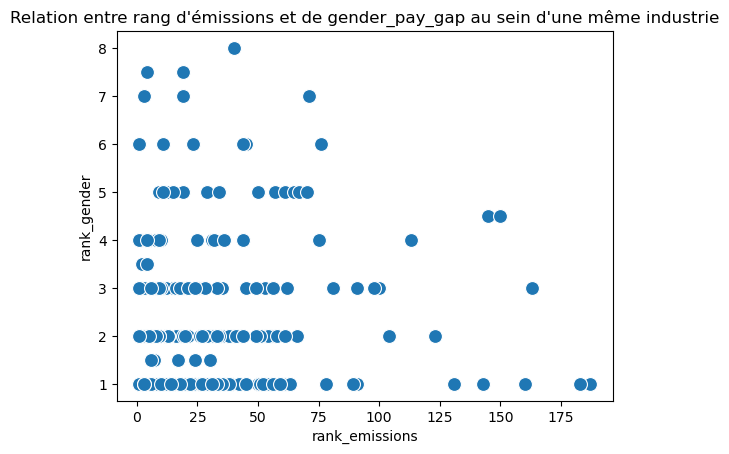

In [152]:
df3['rank_gender'] = df3.groupby(['primary_industry', 'year'])['gender_pay_gap'].rank(ascending=False)
df3['rank_emissions'] = df3.groupby(['primary_industry', 'year'])['most_emitting_scope'].rank(ascending=False)
df3 = df3.dropna(subset = ['rank_gender', 'rank_emissions'])

sns.scatterplot(x = 'rank_emissions', y = 'rank_gender', data = df3, palette='viridis', s=100)
plt.title("Relation entre rang d'émissions et de gender_pay_gap au sein d'une même industrie")

On effectue une régression en contrôlant de nouveau sur la région et l'année.

In [153]:
# Régressions linéaires avec contrôle sur la région et l'année
X = df3[['rank_emissions', 'region', 'year', 'primary_industry']]
X = pd.get_dummies(X, columns=['region', 'year', 'primary_industry'], drop_first=True, dtype=float)
X = sm.add_constant(X)

y = df3['rank_gender']

model = sm.OLS(y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            rank_gender   R-squared:                       0.467
Model:                            OLS   Adj. R-squared:                  0.245
Method:                 Least Squares   F-statistic:                     2.101
Date:                Wed, 14 Feb 2024   Prob (F-statistic):           6.77e-06
Time:                        12:55:21   Log-Likelihood:                -458.36
No. Observations:                 303   AIC:                             1097.
Df Residuals:                     213   BIC:                             1431.
Df Model:                          89                                         
Covariance Type:            nonrobust                                         
                                                                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------

# Impact de la formation

On va faire des tests sur les heures de formation et les facteurs environnementaux et sociaux.

In [147]:
df4 = df.dropna(subset = ['gender_pay_gap', 'hours_of_training'])
df4['hours_of_training_per_capita'] = df4['hours_of_training']/df4['employees']

# Régressions linéaires avec contrôle sur la région et l'année
X = df4[['hours_of_training_per_capita', 'region', 'year', 'primary_industry']]
X = pd.get_dummies(X, columns=['region', 'year', 'primary_industry'], drop_first=True, dtype=float)
X = sm.add_constant(X)

mask = ~X.isin([np.nan, np.inf, -np.inf]).any(axis=1)
X = X[mask]
y = df4['gender_pay_gap'][mask]

#model = sm.OLS(y, X).fit()

model_clustered = sm.OLS(y, X).fit(cov_type='cluster',
                                   cov_kwds={'groups': df4['year'][mask]})

for line in model_clustered.summary().as_text().splitlines()[:16]:
    print(line[:])

                            OLS Regression Results                            
Dep. Variable:         gender_pay_gap   R-squared:                       0.477
Model:                            OLS   Adj. R-squared:                  0.229
Method:                 Least Squares   F-statistic:                 1.072e+13
Date:                Wed, 14 Feb 2024   Prob (F-statistic):           9.32e-14
Time:                        12:53:13   Log-Likelihood:                -944.92
No. Observations:                 268   AIC:                             2064.
Df Residuals:                     181   BIC:                             2376.
Df Model:                          86                                         
Covariance Type:              cluster                                         
                                                                      coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------

/tmp/ipykernel_2885/897556551.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df4['hours_of_training_per_capita'] = df4['hours_of_training']/df4['employees']
/opt/mamba/lib/python3.11/site-packages/statsmodels/base/model.py:1896: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 86, but rank is 4
  warnings.warn('covariance of constraints does not have full '


In [176]:
df5 = df

df5["nan_industry"] = df5.apply(nan_industry, axis = 1)
idx = df5.loc[df5["nan_industry"] == True].index.to_list()
df5 = df5.drop(index = idx)
df5 = df5.drop(columns = ["nan_industry"])

df5['most_emitting_scope'] = df5.apply(most_emitting_scope_function, axis = 1)
df5 = df5.dropna(subset=['most_emitting_scope'])

In [183]:
df5['hours_of_training_per_capita'] = df5['hours_of_training']/df5['employees']
df5['sum_scope_per_capita'] = df5['scope_1_per_capita'] + df5['scope_2_per_capita'] + df5['scope_3_per_capita']

# Régressions linéaires avec contrôle sur la région et l'année
X = df5[['hours_of_training_per_capita', 'region', 'year', 'primary_industry']]
X = pd.get_dummies(X, columns=['region', 'year', 'primary_industry'], drop_first=True, dtype=float)
X = sm.add_constant(X)

mask = ~X.isin([np.nan, np.inf, -np.inf]).any(axis=1)
X = X[mask]
y = df5['sum_scope_per_capita'][mask]

model = sm.OLS(y, X).fit()

#model_clustered = sm.OLS(y, X).fit(cov_type='cluster',
                                   #cov_kwds={'groups': df5['year'][mask]})

#for line in model_clustered.summary().as_text().splitlines()[:16]:
    #print(line[:])

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:     scope_1_per_capita   R-squared:                         nan
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Wed, 14 Feb 2024   Prob (F-statistic):                nan
Time:                        13:19:41   Log-Likelihood:                    nan
No. Observations:                2974   AIC:                               nan
Df Residuals:                    2821   BIC:                               nan
Df Model:                         152                                         
Covariance Type:            nonrobust                                         
                                                                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------

In [165]:
#print(df5['hours_of_training_per_capita'].dropna())

Je vais juste essayer de mettre en log les émissions.

In [158]:
#df6 = df5.loc[df5['most_emitting_scope'] != 0]
#df6['most_emitting_scope_log'] = np.log(df6['most_emitting_scope'])
df5['sum_scope_per_capita_log'] = np.log(df5['sum_scope_per_capita'])

# Régressions linéaires avec contrôle sur la région et l'année
X = df5[['hours_of_training_per_capita', 'region', 'year', 'primary_industry']]
X = pd.get_dummies(X, columns=['region', 'year', 'primary_industry'], drop_first=True, dtype=float)
X = sm.add_constant(X)

mask = ~X.isin([np.nan, np.inf, -np.inf]).any(axis=1)
X = X[mask]
y = df5['sum_scope_per_capita_log'][mask]

#model = sm.OLS(y, X).fit()

model_clustered = sm.OLS(y, X).fit(cov_type='cluster',
                                   cov_kwds={'groups': df5['year'][mask]})
print(model_clustered.summary())

/opt/mamba/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


ValueError: r_matrix performs f_test for using dimensions that are asymptotically non-normal